In [1]:
import autograd.numpy as np
from autograd import grad, jacobian
from scipy.integrate import solve_ivp
from scipy import optimize
import matplotlib.pyplot as plt


In [2]:


# Define HH model parameters
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0   # Potassium conductance (mS/cm^2)
g_L = 0.3    # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -55.0  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define the HH model equations
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

# Define the HH model differential equations
def hodgkin_huxley_eq(V, m, h, n, I, t):
    #I = I_params[0]*np.sin(I_params[1]*t)
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt

# Define time parameters
# dt = 0.01  # Time step (ms)
# t = np.arange(0, 50, dt)  # Time vector (ms)
dt = 0.025
t = np.arange(0, 250, dt)


# Initialize state variables
V0 = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables


In [3]:
def forward_model(I_params, V0, m, h, n, dt, t):
        
    V_record = []
    V = V0
    
    I = np.zeros_like(t)
    I[100:500] = I_params[0]
    
    for i in range(len(t)):
        
        # run forward step
        V_record.append(V)
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I[i], t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt
        
    return V_record  

## Adjoint

### Import Data

In [ ]:
import zipfile
import csv

with zipfile.ZipFile('./sim_data/gt_multa.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
with open('gt_multa.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
    
data_steps = [row[0] for row in data][1:-1] # extract time data
data_steps = np.array([float(i) for i in data_steps]) # convert to numpy array of floats

V_data = [row[1] for row in data][1:-1]
V_data = np.array([float(i) for i in V_data])

I_data = [row[2] for row in data][1:-1]
I_data = np.array([float(i) for i in I_data])

len(V_data)

In [ ]:
plt.plot(data_steps, V_data, label = 'V')
plt.plot(data_steps, I_data, label = 'I')
plt.xlabel('time')
plt.legend()

#### Fake Data

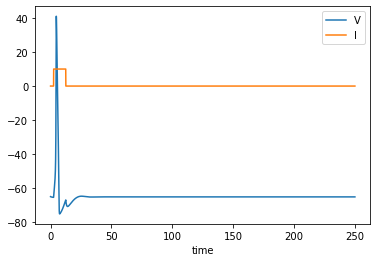

In [4]:
# run forward model to create fake data

#A = 4.289
#w = 0.1

#A = 4.5
#w = 0.1

A = 10.0
I_params = np.array([A])

#I_params = np.array([A, w])

V_record = forward_model(I_params, V0, m, h, n, dt, t)

#I_stimulus = A*np.sin(w*t)
I_stimulus = np.zeros_like(t)
I_stimulus[100:500] = I_params[0]

plt.plot(t, V_record, label = 'V')
plt.plot(t, I_stimulus, label = 'I')
plt.xlabel('time')
plt.legend()



In [11]:
V_subsamp = V_record#[::10]
    
mean = np.mean(V_record)
stddev = np.std(V_record)

#noise = np.random.normal(0, stddev, len(V_subsamp))
noise = np.random.normal(0,1,len(V_subsamp))
V_data = V_subsamp + noise

data_steps = t#[::10]

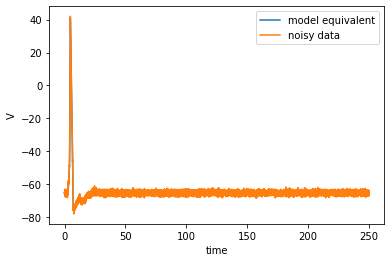

In [12]:
plt.plot(t, V_record, label = 'model equivalent')
plt.plot(data_steps, V_data, label = 'noisy data')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

### Define cost function

In [13]:
def elu_norm(voltage, thresh, alpha = 0.001):
    exponentiated_values = np.where(voltage <= np.ones(len(voltage))*thresh, alpha*(np.exp(voltage)-np.exp(thresh)), voltage)
    return exponentiated_values


def lagrange_seq(I_array, y_true, y_pred, alpha = .001, beta = 1e3, gamma = 1e2, thresh = -55):
    
    #penalty term for deviation from desired number of action potentials
    #ap_true = ap_count(y_true, thresh)
    #ap_pred = ap_count(y_pred, thresh)
    #mse_ap = (ap_pred - ap_true)**2
    normed_true = elu_norm(y_true, thresh, alpha)
    normed_pred = elu_norm(y_pred, thresh)
    mse_ap= normed_true-normed_pred
    
    #pred_ener = np.sum(np.square(input_current))
    #true_ener = np.sum(np.square(current_true))
   # mse_energy = np.mean(np.square(pred_ener-true_ener))
    
    loss = gamma * 1/len(y_true)* mse_ap + beta * np.linalg.norm(I_array)
    return np.sum(loss)



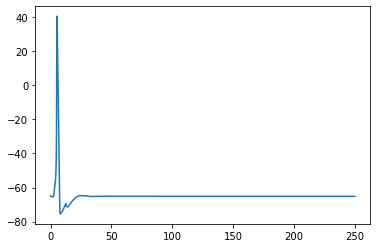

In [14]:
# # first guess
# A = 2.0
# w = 0.02

# A = 4.5
# w = 0.1

# I_params = np.array([A, w])

A = 7.0
I_params = np.array([A])

V_model = forward_model(I_params, V0, m, h, n, dt, t)
plt.plot(t, V_model)     

#### Compute Gradient

In [15]:
# find gradient

#grad_AD = grad(forward_model_cost, 0) # 0 indicates differentiation w.r.t. the first argument of f.
grad_AD = grad(lagrange_seq, 0)

In [18]:
# test autograd with I_params used to create fake data

#grad_AD(I_params, V0, m, h, n, dt, t, data_steps, V_data)
I = np.zeros_like(t)
I[100:500] = I_params[0]

grad_AD(I, V_model, V_data)

array([0., 0., 0., ..., 0., 0., 0.])

#### FD Check

In [ ]:
# # # FD check wrt A

# # A1 = np.random.uniform(0,5)
# # L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

# # p = np.random.randint(0,5000)
# # s = 1e-7 # step size
# # A2 = A1 + s*p
# # L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
# # dL_dV_p_diff = (L2 - L1) / s

# # g = grad_AD(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)[0]
# # dL_dV_p = np.dot(g, p)

# # grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
# # print('step size=', s, ', gradient finite difference error=', grad_err)



# # FD check wrt w

# w1 = np.random.uniform(0, 1)
# V1 = forward_model(np.array([A, w1]), V0, m, h, n, dt, t)
# L1 = lagrange_seq(np.array([A, w1]), V1, V_data)

# p = np.random.randint(0,5000)
# s = 1e-7 # step size
# w2 = w1 + s*p
# V2 = forward_model(np.array([A, w2]), V0, m, h, n, dt, t)
# L2 = lagrange_seq(np.array([A, w2]), V2, V_data)
# dL_dV_p_diff = (L2 - L1) / s

# g = grad_AD(np.array([A, w1]), V1, V_data)[1]
# dL_dV_p = np.dot(g, p)

# grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
# print('step size=', s, ', gradient finite difference error=', grad_err)



In [ ]:
# step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# # Make log-log plot of gradient finite difference error vs. step size

# w1 = np.random.uniform(0, 1)
# V1 = forward_model(np.array([A, w1]), V0, m, h, n, dt, t)
# L1 = lagrange_seq(np.array([A, w1]), V1, V_data)


# # compute gradient using autograd
# g = grad_AD(np.array([A, w1]), V1, V_data)[1]
# dL_dV_p = np.dot(g, p)


# grad_errs = list()
# for s in step_sizes:
    
#     # compute gradient using finite differences
#     w2 = w1 + s*p

#     V2 = forward_model(np.array([A, w2]), V0, m, h, n, dt, t)
#     L2 = lagrange_seq(np.array([A, w2]), V2, V_data)
#     dL_dV_p_diff = (L2 - L1) / s


#     # compute gradient error
#     grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
#     print('step size=', s, ', example gradient finite difference error=', grad_err)
    
#     grad_errs.append(grad_err)

# plt.loglog(step_sizes, grad_errs)
# plt.title('Example finite difference gradient check')
# plt.xlabel('step size')
# plt.ylabel('error')


In [21]:
step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
p = np.random.randint(0,5000)

# Make log-log plot of gradient finite difference error vs. step size

A1 = np.random.uniform(0,20)
V1 = forward_model(np.array([A1]), V0, m, h, n, dt, t)
L1 = lagrange_seq(np.array([A1]), V1, V_data)

# compute gradient using autograd
g = grad_AD(np.array([A1]), V1, V_data)[0]
# dL_dV_p = np.dot(g, p)

# # j = jac_AD(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)
# # dL_dV_p = np.dot(j, p)


# grad_errs = list()
# for s in step_sizes:
    
#     # compute gradient using finite differences
#     A2 = A1 + s*p

#     V2 = forward_model(np.array([A2]), V0, m, h, n, dt, t)
#     L2 = lagrange_seq(np.array([A2]), V2, V_data)
#     dL_dV_p_diff = (L2 - L1) / s


#     # compute gradient error
#     grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
#     print('step size=', s, ', example gradient finite difference error=', grad_err)
    
#     grad_errs.append(grad_err)

# plt.loglog(step_sizes, grad_errs)
# plt.title('Example finite difference gradient check')
# plt.xlabel('step size')
# plt.ylabel('error')


grad_AD(np.array([A1]), V1, V_data)

array([10000000.])

#### Find Minimizer

In [ ]:
A, w

In [ ]:
# A = 4.289
# w = 0.1


#initial_guess = np.array([4.0, w])
initial_guess = np.array([A, w])

# optim = optimize.minimize(forward_model_cost, initial_guess, args = (V0, m, h, n, dt, t, data_steps, V_data), 
#                   jac = grad_AD, method = 'BFGS')

optim = optimize.minimize(lagrange_seq, initial_guess, args = (V_model, V_data), 
                   jac = grad_AD, method = 'BFGS')

optim


In [ ]:
optim.x

In [ ]:
# norm_g = np.linalg.norm(g_func(Ak))
# print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

V_final = forward_model(optim.x, V0, m, h, n, dt, t)

plt.figure()
plt.plot(V_final, ls = 'dotted', label = 'with optimized I')
plt.plot(V_data, label = 'original')
#plt.title('V (steepest descent)')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()